# Validation of linearization

**Author**: Seogi Kang

This notebook validates the linearization of IP data. Although this result is not shown in Kang and Oldenburg (2019), this will be helpful for ones who are curious about under what conditions the linearization is valid. 

In [1]:
from SimPEG import DC
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
%pylab inline
from matplotlib import colors
import h5py
from pylab import cm
from matplotlib import gridspec
import matplotlib
matplotlib.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Button', 'Widget', 'interactive', 'Text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load 2D models

In [2]:
fname = 'model_2d.h5'
model_2d = h5py.File(fname, 'r')
sigma = model_2d['sigma_2d'].value
eta = model_2d['eta_2d'].value
tau = model_2d['tau_2d'].value
c = model_2d['c_2d'].value

/Users/sgkang/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
eta_inds = eta == 0.1

In [5]:
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(fname, 'r')

IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)

In [6]:
line_inds = IO_3d.line_inds == 2

In [18]:
def run_fwd_dc(sigma):
    IO_2d = DC.IO()
    survey_2d = IO_2d.from_ambn_locations_to_survey(
        survey_type='dipole-dipole',
        a_locations=output_simulation['a_locations'].value[line_inds,:][:,[0, 2]],
        b_locations=output_simulation['b_locations'].value[line_inds,:][:,[0, 2]],
        m_locations=output_simulation['m_locations'].value[line_inds,:][:,[0, 2]],
        n_locations=output_simulation['n_locations'].value[line_inds,:][:,[0, 2]],
        data_dc=output_simulation['dc_data'].value[line_inds],
        data_dc_type='volt',
        data_sip=output_simulation['sip_data'].value[line_inds,:],    
        data_sip_type='volt',
        dimension=2
    )
    mesh_2d, actind = IO_2d.set_mesh(dx=12.5, dz=10.)
    actMap = Maps.InjectActiveCells(mesh_2d, actind, valInactive=np.log(1e-8))
    sigmaMap = Maps.ExpMap(mesh_2d)*actMap

    problem_dc = DC.Problem2D_N(
        mesh_2d, sigmaMap=sigmaMap,
        storeJ=True,
        Solver=PardisoSolver
    )
    problem_dc.pair(survey_2d)
    core_2d_inds, mesh_2d_core = Utils.ExtractCoreMesh(IO_2d.xyzlim, mesh_2d)    
    return survey_2d.dpred(np.log(sigma)), mesh_2d, actind, survey_2d


In [8]:
def run_fwd_ip(sigma, eta):
    from SimPEG import IP
    actMap_ip = Maps.InjectActiveCells(mesh_2d, actind, valInactive=0.)
    survey_2d_ip = IP.from_dc_to_ip_survey(survey_2d)
    problem_ip = IP.Problem2D_N(
        mesh_2d, sigma=sigma, etaMap=actMap_ip,
        storeJ=False,
        Solver=PardisoSolver
    )
    problem_ip.pair(survey_2d_ip)    
    return survey_2d_ip.dpred(eta)

In [19]:
sigma_inf = sigma.copy()
d_inf, mesh_2d, actind, survey_2d = run_fwd_dc(sigma_inf)

In [20]:
etas = np.arange(9)*0.1+0.1
eta_temp = eta.copy()
d_0s = []
d_IPs = []
d_IPs_approx_0 = []
d_IPs_approx_inf = []
floor = 1e-4
for eta_value in etas:
    eta_temp[eta_inds] = eta_value
    sigma0 = sigma_inf*(1.-eta_temp)
    d0_temp, _, _, _ = run_fwd_dc(sigma0)
    d_IP_temp = d0_temp-d_inf
    d_IP_approx_0_temp = run_fwd_ip(sigma0, eta_temp)    
    d_IP_approx_inf_temp = run_fwd_ip(sigma_inf, eta_temp)        
    d_0s.append(d0_temp)    
    d_IPs.append(d_IP_temp)
    d_IPs_approx_inf.append(d_IP_approx_inf_temp)
    d_IPs_approx_0.append(d_IP_approx_0_temp)    
    misfit_inf = abs(d_IP_temp-d_IP_approx_inf_temp)/(abs(d_IP_temp)+floor)
    misfit_0 = abs(d_IP_temp-d_IP_approx_0_temp)/(abs(d_IP_temp)+floor)
    rms_inf = np.sqrt((misfit_inf**2).sum())/d0_temp.size * 100
    rms_0 = np.sqrt((misfit_0**2).sum())/d0_temp.size * 100    
    print (
        ("eta: %.1f, rms (inf) error: %.1f percent, rms (0) error: %.1f percent") % 
        (eta_value, rms_inf, rms_0)
    )        

eta: 0.1, rms (inf) error: 0.8 percent, rms (0) error: 0.3 percent
eta: 0.2, rms (inf) error: 1.3 percent, rms (0) error: 0.7 percent
eta: 0.3, rms (inf) error: 1.9 percent, rms (0) error: 1.2 percent
eta: 0.4, rms (inf) error: 2.4 percent, rms (0) error: 1.9 percent
eta: 0.5, rms (inf) error: 3.1 percent, rms (0) error: 2.7 percent
eta: 0.6, rms (inf) error: 4.2 percent, rms (0) error: 4.0 percent
eta: 0.7, rms (inf) error: 17.5 percent, rms (0) error: 13.4 percent
eta: 0.8, rms (inf) error: 16.8 percent, rms (0) error: 9.9 percent
eta: 0.9, rms (inf) error: 8.3 percent, rms (0) error: 6.8 percent


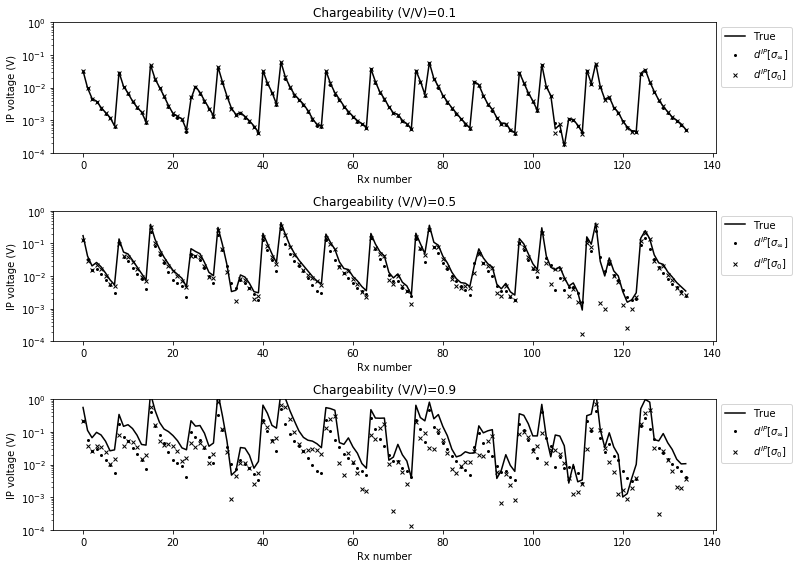

In [21]:
iis = [0, 4, 8]
fig, axs = plt.subplots(3,1, figsize=(14*0.8,10*0.8))
for iax, i in enumerate(iis):
    axs[iax].semilogy(abs(d_IPs[i]), 'k')
    axs[iax].semilogy(abs(d_IPs_approx_inf[i]), 'k.', ms=4)
    axs[iax].semilogy(abs(d_IPs_approx_0[i]), 'kx', ms=4)    
    axs[iax].set_ylim(1e-4, 10e-1)
    axs[iax].set_xlabel("Rx number")
    axs[iax].set_ylabel("IP voltage (V)")    
    axs[iax].legend(
        ("True", "$d^{IP}[\sigma_{\infty}]$", "$d^{IP}[\sigma_{0}]$"), 
        bbox_to_anchor=(1,1)
    )
    axs[iax].set_title(("Chargeability (V/V)=%.1f")%(etas[i]))
plt.tight_layout()